In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df  = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

In [3]:
df  = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
## To check null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df['Age']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [7]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [8]:
# Age, Fare, Embarked have null values so we are doing mean, median and alphabet imputation
df['Age'] = df.Age.fillna(df.Age.mean())
df['Fare'] = df.Fare.fillna(df.Fare.median())
df['Embarked'] = df['Embarked'].fillna('S') ## as it has high value count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
## To check all the unique values in a dataset
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             89
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [10]:
## As age cannot be in float
df = df.astype({"Age": int})

In [11]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,C148,C


In [12]:
# To check particular passenger had a cabin or not?
## here is null gives true wherever it finds nan value but we want true where it doesnot have nan values so we used tilt symbol
df['Cabin_Exist'] = ~df.Cabin.isnull()
## show data
df.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Exist
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,True
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,False
5,6,0,3,"Moran, Mr. James",male,29,0,0,330877,8.4583,NaN,Q,False


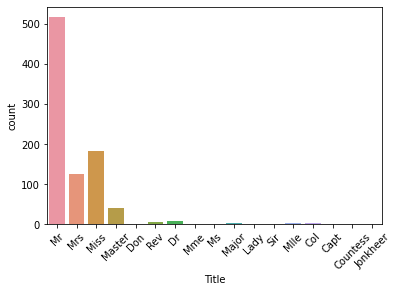

In [13]:
## This lamda re.seach will give the title of the names as we choose group1 out of it
df['Title'] = df.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=df);
plt.xticks(rotation=45);

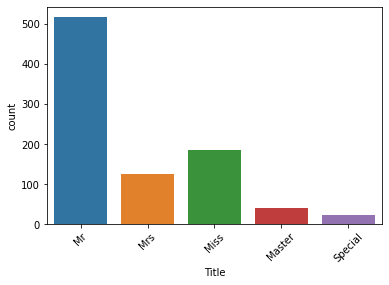

In [14]:
## we did this in order to know reduce the categories
df['Title'] = df['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
df['Title'] = df['Title'].replace(['Don', 'Dona', 'Rev', 'Dr',
                                            'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'],'Special')
sns.countplot(x='Title', data=df);
plt.xticks(rotation=45);

In [15]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Exist,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,False,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,True,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,False,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,True,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,False,Mr
5,6,0,3,"Moran, Mr. James",male,29,0,0,330877,8.4583,NaN,Q,False,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S,True,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S,False,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S,False,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C,False,Mrs


In [16]:
# grouping numerical columns
## q stands for quartile range for eg it will try to group data in 4 bins having 0-15%, 15-35%, 35-51%, 51-78% and 78-100%.
## It segregates data based on datapoints like its checks whether the datapoint lies in first 15% of the data, or next(15-35)15% of data
df['Age_Group'] = pd.qcut(df.Age, q=4, labels=False)
df['Fare_range']= pd.qcut(df.Fare, q=4, labels=False)
df.head(11)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Exist,Title,Age_Group,Fare_range
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,False,Mr,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,True,Mrs,3,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,False,Miss,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,True,Mrs,2,3
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,False,Mr,2,1
5,6,0,3,"Moran, Mr. James",male,29,0,0,330877,8.4583,NaN,Q,False,Mr,1,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S,True,Mr,3,3
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S,False,Master,0,2
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S,False,Mrs,1,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C,False,Mrs,0,2


In [17]:
## Now we will do feature selection
## we will remove coloumns that are unrelevant for us
df.drop(['Cabin', 'Name', 'PassengerId', 'Ticket', 'Fare','Age'], axis=1, inplace=True)
df.head(6)

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Cabin_Exist,Title,Age_Group,Fare_range
0,0,3,male,1,0,S,False,Mr,0,0
1,1,1,female,1,0,C,True,Mrs,3,3
2,1,3,female,0,0,S,False,Miss,1,1
3,1,1,female,1,0,S,True,Mrs,2,3
4,0,3,male,0,0,S,False,Mr,2,1
5,0,3,male,0,0,Q,False,Mr,1,1


In [18]:
## Add a feature or column as we can observe Parch meaning parent and sibling meaqns child so we can create a column named Family merging 2 columns in 1
df['Family'] = df.Parch + df.SibSp
df.head(10)

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Cabin_Exist,Title,Age_Group,Fare_range,Family
0,0,3,male,1,0,S,False,Mr,0,0,1
1,1,1,female,1,0,C,True,Mrs,3,3,1
2,1,3,female,0,0,S,False,Miss,1,1,0
3,1,1,female,1,0,S,True,Mrs,2,3,1
4,0,3,male,0,0,S,False,Mr,2,1,0
5,0,3,male,0,0,Q,False,Mr,1,1,0
6,0,1,male,0,0,S,True,Mr,3,3,0
7,0,3,male,3,1,S,False,Master,0,2,4
8,1,3,female,0,2,S,False,Mrs,1,1,2
9,1,2,female,1,0,C,False,Mrs,0,2,1


In [19]:
## again we will drop the column
df =  df.drop(['SibSp','Parch'], axis=1)
df.head()

,Survived,Pclass,Sex,Embarked,Cabin_Exist,Title,Age_Group,Fare_range,Family
0,0,3,male,S,False,Mr,0,0,1
1,1,1,female,C,True,Mrs,3,3,1
2,1,3,female,S,False,Miss,1,1,0
3,1,1,female,S,True,Mrs,2,3,1
4,0,3,male,S,False,Mr,2,1,0


In [20]:
df

,Survived,Pclass,Sex,Embarked,Cabin_Exist,Title,Age_Group,Fare_range,Family
0,0,3,male,S,False,Mr,0,0,1
1,1,1,female,C,True,Mrs,3,3,1
2,1,3,female,S,False,Miss,1,1,0
3,1,1,female,S,True,Mrs,2,3,1
4,0,3,male,S,False,Mr,2,1,0
...,...,...,...,...,...,...,...,...,...
886,0,2,male,S,False,Special,1,1,0
887,1,1,female,S,True,Miss,0,2,0
888,0,3,female,S,False,Miss,1,2,3
889,1,1,male,C,True,Mr,1,2,0


In [21]:
## now we will convert categorical data into binary as it helps to get good relationship when training ML model
df_one_hot_encoding = pd.get_dummies(df,drop_first=True)
df_one_hot_encoding.head(6)

,Survived,Pclass,Cabin_Exist,Age_Group,Fare_range,Family,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Special
0,0,3,False,0,0,1,1,0,1,0,1,0,0
1,1,1,True,3,3,1,0,0,0,0,0,1,0
2,1,3,False,1,1,0,0,0,1,1,0,0,0
3,1,1,True,2,3,1,0,0,1,0,0,1,0
4,0,3,False,2,1,0,1,0,1,0,1,0,0
5,0,3,False,1,1,0,1,1,0,0,1,0,0


In [32]:
df_one_hot_encoding = df_one_hot_encoding.drop(['Survived'], axis=1)
df_one_hot_encoding.head()

,Pclass,Cabin_Exist,Age_Group,Fare_range,Family,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Special
0,3,False,0,0,1,1,0,1,0,1,0,0
1,1,True,3,3,1,0,0,0,0,0,1,0
2,3,False,1,1,0,0,0,1,1,0,0,0
3,1,True,2,3,1,0,0,1,0,0,1,0
4,3,False,2,1,0,1,0,1,0,1,0,0


## OUR DATA IS ALL SET TO GET TRAINED !!

# Standarization Vs Normalization

##  Normalization(min-max Normalization)

### Here, we try to  scale down values of feature between 0 to 1
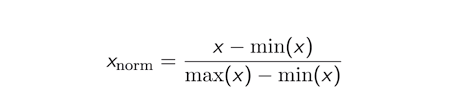

### Importing MinMaxScalar library 

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
scaling = MinMaxScaler()

### This features is noted down based on various units and magnitude.So there is a huge difference between these features..its scaled down to 0 to 1. So all features are on same scale.

In [35]:
df_one_hot_encoding.head(3)

,Pclass,Cabin_Exist,Age_Group,Fare_range,Family,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Special
0,3,False,0,0,1,1,0,1,0,1,0,0
1,1,True,3,3,1,0,0,0,0,0,1,0
2,3,False,1,1,0,0,0,1,1,0,0,0


In [41]:
new_list = list(df_one_hot_encoding.columns)
new_list

['Pclass',
 'Cabin_Exist',
 'Age_Group',
 'Fare_range',
 'Family',
 'Sex_male',
 'Embarked_Q',
 'Embarked_S',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Special']

In [42]:
scaled = scaling.fit_transform(df_one_hot_encoding)
scaled = pd.DataFrame(scaled, columns=new_list)

In [43]:
print("Scaled Dataset Using MinMaxScaler")
scaled.head()

Scaled Dataset Using MinMaxScaler


,Pclass,Cabin_Exist,Age_Group,Fare_range,Family,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Special
0,1.0,0.0,0.000000,0.000000,0.1,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,1.000000,1.000000,0.1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.333333,0.333333,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.666667,1.000000,0.1,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.666667,0.333333,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


# Standarization(Standard Scalar)

## All features are transformed in such a way that it will have properties of standard normal distribution where mean = 0 and standard deviation =1
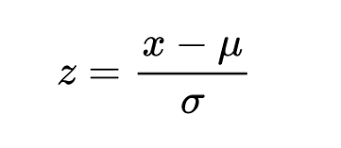

In [44]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
st_sc = scale.fit_transform(df_one_hot_encoding)
st_sc = pd.DataFrame(st_sc, columns=new_list)
print("Scaled Dataset Using StandardScaler")
st_sc.head(6)

Scaled Dataset Using StandardScaler


,Pclass,Cabin_Exist,Age_Group,Fare_range,Family,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Special
0,0.827377,-0.544925,-1.219232,-1.339737,0.059160,0.737695,-0.307562,0.615838,-0.511898,0.850532,-0.405840,-0.162781
1,-1.566107,1.835115,1.480856,1.344758,0.059160,-1.355574,-0.307562,-1.623803,-0.511898,-1.175735,2.464027,-0.162781
2,0.827377,-0.544925,-0.319202,-0.444905,-0.560975,-1.355574,-0.307562,0.615838,1.953514,-1.175735,-0.405840,-0.162781
3,-1.566107,1.835115,0.580827,1.344758,0.059160,-1.355574,-0.307562,0.615838,-0.511898,-1.175735,2.464027,-0.162781
4,0.827377,-0.544925,0.580827,-0.444905,-0.560975,0.737695,-0.307562,0.615838,-0.511898,0.850532,-0.405840,-0.162781
5,0.827377,-0.544925,-0.319202,-0.444905,-0.560975,0.737695,3.251373,-1.623803,-0.511898,0.850532,-0.405840,-0.162781


## When to use Standarization or Normalization ??

### Scenario : Machine Learning algorithms that involves Euclidean Distance and Some Depp learning techiniques where gradient descent is involved where you need to find best minimal  point. To get to that point we have algorithms like K-means, KNN, Linear Regression, Logistic Regression all deep learning networks
### Standarization mostly performs well than Normalization.

### You don't need to perform Scaling when you go for decision Tree, Random Forest, XGBoost or all boosting technics.

### Now, we will convert the pandas dataframe into spark dataframe

In [45]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

In [46]:
spark = SparkSession.builder.appName("Feature-Engineering with Spark").getOrCreate()

### Create PySpark DataFrame from Pandas

In [51]:
sparkDF=spark.createDataFrame(st_sc) 
sparkDF.printSchema()
sparkDF.show(10)

root
 |-- Pclass: double (nullable = true)
 |-- Cabin_Exist: double (nullable = true)
 |-- Age_Group: double (nullable = true)
 |-- Fare_range: double (nullable = true)
 |-- Family: double (nullable = true)
 |-- Sex_male: double (nullable = true)
 |-- Embarked_Q: double (nullable = true)
 |-- Embarked_S: double (nullable = true)
 |-- Title_Miss: double (nullable = true)
 |-- Title_Mr: double (nullable = true)
 |-- Title_Mrs: double (nullable = true)
 |-- Title_Special: double (nullable = true)

+-------------------+-------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------------+--------------------+--------------------+
|             Pclass|        Cabin_Exist|           Age_Group|         Fare_range|              Family|           Sex_male|         Embarked_Q|         Embarked_S|         Title_Miss|          Title_Mr|           Title_Mrs|       Title_Special|
+---------

In [52]:
cols = sparkDF.columns
assembler = VectorAssembler(inputCols=cols,outputCol="list_of_features")
data = assembler.transform(sparkDF)
data.select("list_of_features").show(10,truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|list_of_features                                                                                                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.8273772438659699,-0.5449249778098341,-1.2192317274280378,-1.3397369794696112,0.059159876663617696,0.7376951317802901,-0.3075623426146228,0.6158384251930635,-0.5118980953829163,0.8505317485662419,-0.40583972495671383,-0.16278112867447064] |
|[-1.5661069258891576,1.